# Import modules

In [5]:
#-----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
#-----------------------------------------------------------
import os

import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
# DATA INFORMATION

PREV_INPUT = 144
PREDICT = 12

# DATASET PREPARATION

## Dataset Analytics

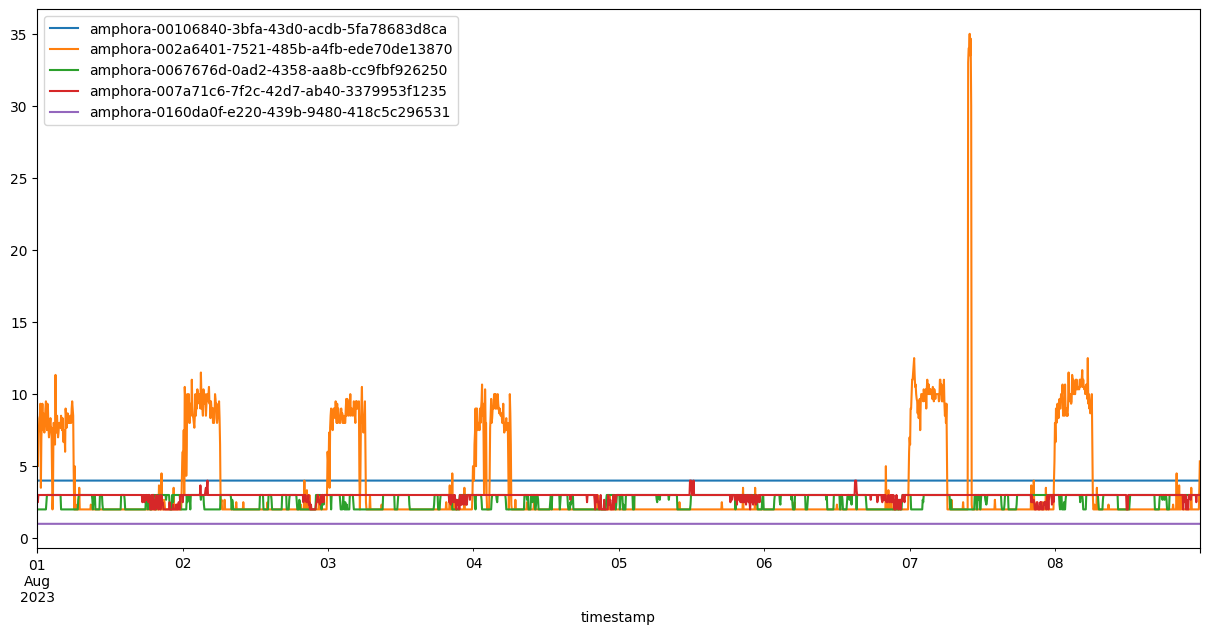

In [7]:
#-----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
#-----------------------------------------------------------

raw_df = pd.read_csv('../data/original_data/1_aug_8_aug/data-cpu-perc.csv')
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])

# Use pivot to transform the DataFrame
raw_df = raw_df.pivot_table(index='timestamp', columns='hostname', values='avg')

# Display the resulting DataFrame
raw_df.reset_index(inplace=True)
raw_df.columns.name = None
raw_df = raw_df.set_index('timestamp')


raw_df.isna().sum()
df = raw_df.interpolate(method='linear')


df.plot(figsize=(15, 7))
plt.show()

In [8]:
df.columns

Index(['amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca',
       'amphora-002a6401-7521-485b-a4fb-ede70de13870',
       'amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250',
       'amphora-007a71c6-7f2c-42d7-ab40-3379953f1235',
       'amphora-0160da0f-e220-439b-9480-418c5c296531'],
      dtype='object')

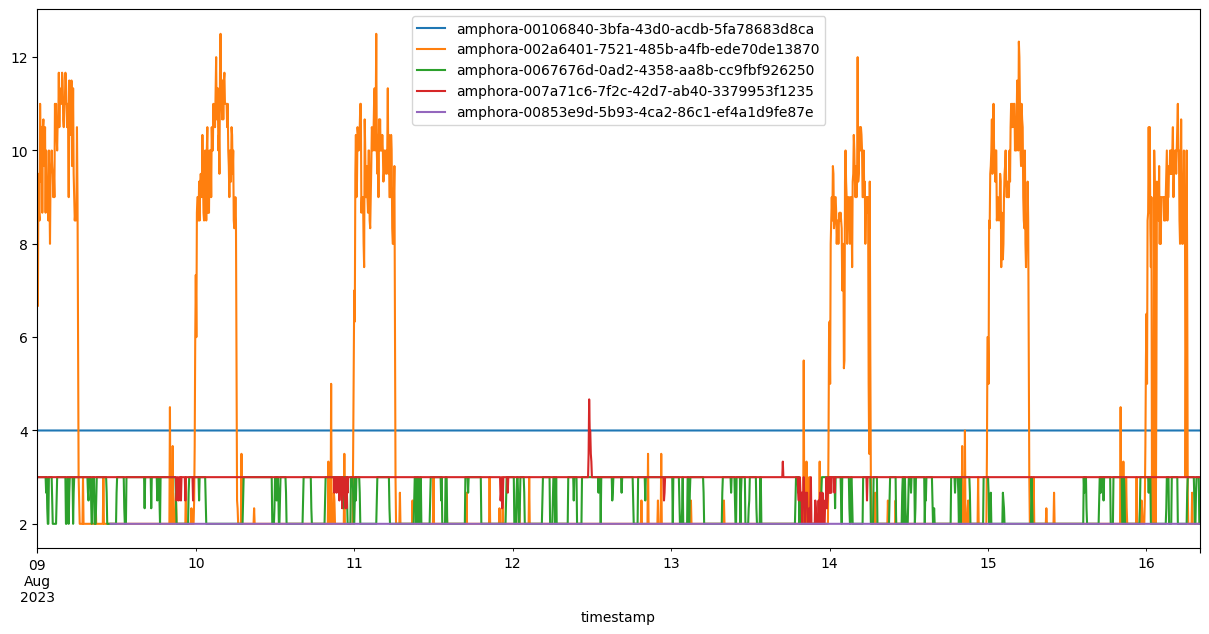

In [4]:
#-----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
#-----------------------------------------------------------

raw_df = pd.read_csv('../data/original_data/9_aug_16_aug/cpu.utilization_norm_perc.csv')
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])

# Use pivot to transform the DataFrame
raw_df = raw_df.pivot_table(index='timestamp', columns='hostname', values='avg')

# Display the resulting DataFrame
raw_df.reset_index(inplace=True)
raw_df.columns.name = None
raw_df = raw_df.set_index('timestamp')


raw_df.isna().sum()
df = raw_df.interpolate(method='linear')


df.plot(figsize=(15, 7))
plt.show()

## Clean Data

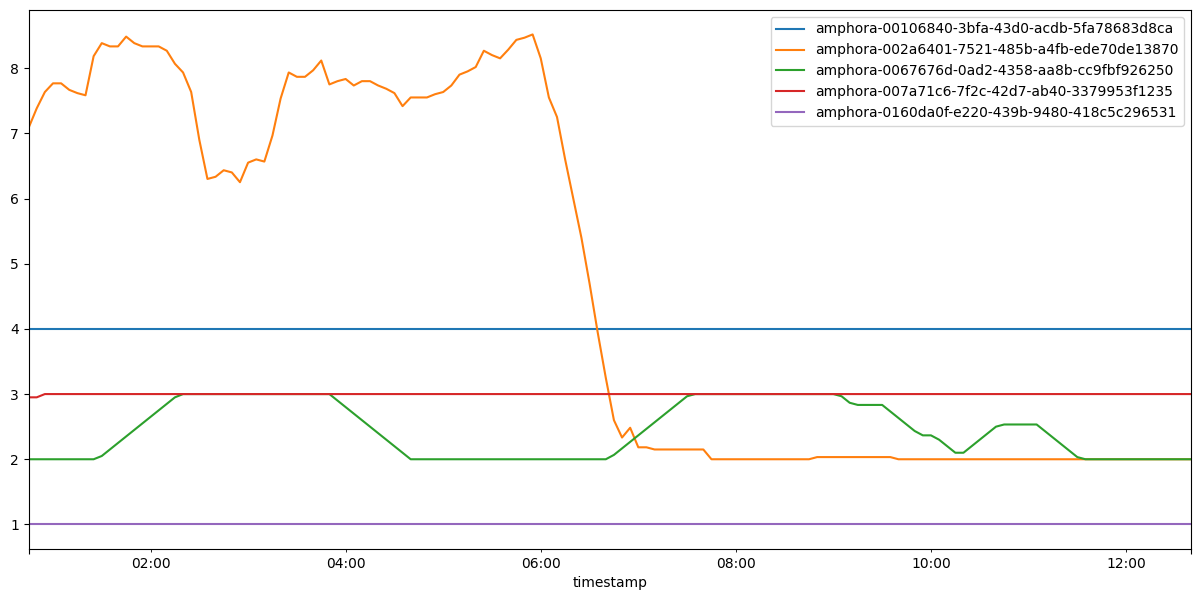

In [9]:
#-----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#-----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
train = train.rolling(window=10).mean().dropna()
test = df[TRAIN_LENGTH : ]

#-----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
#-----------------------------------------------------------
def train_generator(dataset, n_lags, pred):
    dataX, dataY = [], []

    for col_index in range( len(dataset.columns) ):
        col = dataset[dataset.columns[col_index]]
        
        for i in range(len(dataset) - n_lags - pred):
            a = col.iloc[i:(i+n_lags)]
            dataX.append(a)
            dataY.append(col.iloc[i + n_lags: i + n_lags + pred])

    return (np.array(dataX), np.array(dataY))


x_train, y_train = train_generator(train, n_lags = PREV_INPUT, pred = PREDICT)
x_test,  y_test  = train_generator(test,  n_lags = PREV_INPUT, pred = PREDICT)


scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scale = scaler.fit_transform(pd.DataFrame(x_train))
x_test_scale = scaler.transform(pd.DataFrame(x_test))
y_train_scale = scaler.fit_transform(pd.DataFrame(y_train))
y_test_scale = scaler.transform(pd.DataFrame(y_test))

train[:PREV_INPUT].plot(figsize=(15, 7))
plt.show()

# Model

## Set up Model


In [7]:
#-----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(x_train_scale.shape[1], 1),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(PREDICT))

model.summary()


model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())


#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)


checkpoint_path = "./checkpoint/cp"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=999999)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 12)                6156      
                                                                 
Total params: 3158028 (12.05 MB)
Trainable params: 3158028 (12.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
tf.config.list_physical_devices('GPU')

[]

## Train

In [10]:
callbacks = [es , lr_red, cp_callback]
history = model.fit(x_train_scale, y_train_scale,
                    epochs=5, 
                    validation_split=0.25,
                    batch_size=128,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)
# 
#-----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
#-----------------------------------------------------------

Epoch 1/5
 3/46 [>.............................] - ETA: 1:29 - loss: 0.2120

KeyboardInterrupt: 

## Save and Load models

In [ ]:
model.save('./model_8_aug', save_format='tf')

# Evaluation

## Metrics

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(x_train_scale.shape[1], 1),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(7))
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())
model.summary()
model = tf.keras.models.load_model('model/8_aug')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 3155463 (12.04 MB)
Trainable params: 3155463 (12.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#-----------------------------------------------------------
# MAKING PREDICTIONS ON TEST DATA AND PLOTTING PREDICTED AND
# OBSERVED VALUES
#-----------------------------------------------------------
preds = model.predict(x_test_scale)
preds = scaler.inverse_transform(preds)


43/43 [==============================] - 13s 302ms/step


In [12]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

my_array = 1 - abs(y_test[:] - preds[:])/y_test[:]
my_array = my_array = np.where(my_array < 0, 0, my_array)
acc = sum(sum(my_array)/len(y_test))/PREDICT

# mean absolute mean error

print("ACCURACY: ", acc * 100)

Test Score: 1.81 RMSE
Test Score: 0.737284 MAE
Test Score: 24.726689 MAPE
ACCURACY:  81.60550690064116


## Visualization

In [15]:
s = pd.Series(test.index[PREV_INPUT+PREDICT:])
df.columns

Index(['amphora-00106840-3bfa-43d0-acdb-5fa78683d8ca',
       'amphora-002a6401-7521-485b-a4fb-ede70de13870',
       'amphora-0067676d-0ad2-4358-aa8b-cc9fbf926250',
       'amphora-007a71c6-7f2c-42d7-ab40-3379953f1235',
       'amphora-0160da0f-e220-439b-9480-418c5c296531'],
      dtype='object')

In [16]:
test0 = pd.DataFrame(test[ df.columns[0] ])
test1 = pd.DataFrame(test[ df.columns[1] ])
test2 = pd.DataFrame(test[ df.columns[2] ])
test3 = pd.DataFrame(test[ df.columns[3] ])
test4 = pd.DataFrame(test[ df.columns[4] ])

In [17]:
def eval_each_type(test_type):
    x_test, y_test = train_generator(test_type, n_lags = PREV_INPUT, pred = PREDICT)

    scaler = MinMaxScaler(feature_range=(0, 1))
    x_train_scale = scaler.fit_transform(pd.DataFrame(x_train))
    x_test_scale = scaler.transform(pd.DataFrame(x_test))
    y_train_scale = scaler.fit_transform(pd.DataFrame(y_train))
    y_test_scale = scaler.transform(pd.DataFrame(y_test))

    preds = model.predict(x_test_scale)
    preds = scaler.inverse_transform(preds)

    plt.rcParams["figure.figsize"] = (32,12)

    TestY= pd.DataFrame(y_test,columns=[str(i) for i in range(PREDICT)])
    PredY= pd.DataFrame(preds, columns=[str(i) for i in range(PREDICT)])

    TestY.set_index(s, inplace=True)
    PredY.set_index(s, inplace=True)


    plot_max = plt.figure(6)
    plt.plot(TestY['1'])
    plt.plot(PredY['1'])
    # plt.ylim([0, 25])
    plt.show()

9/9 [==============================] - 4s 440ms/step


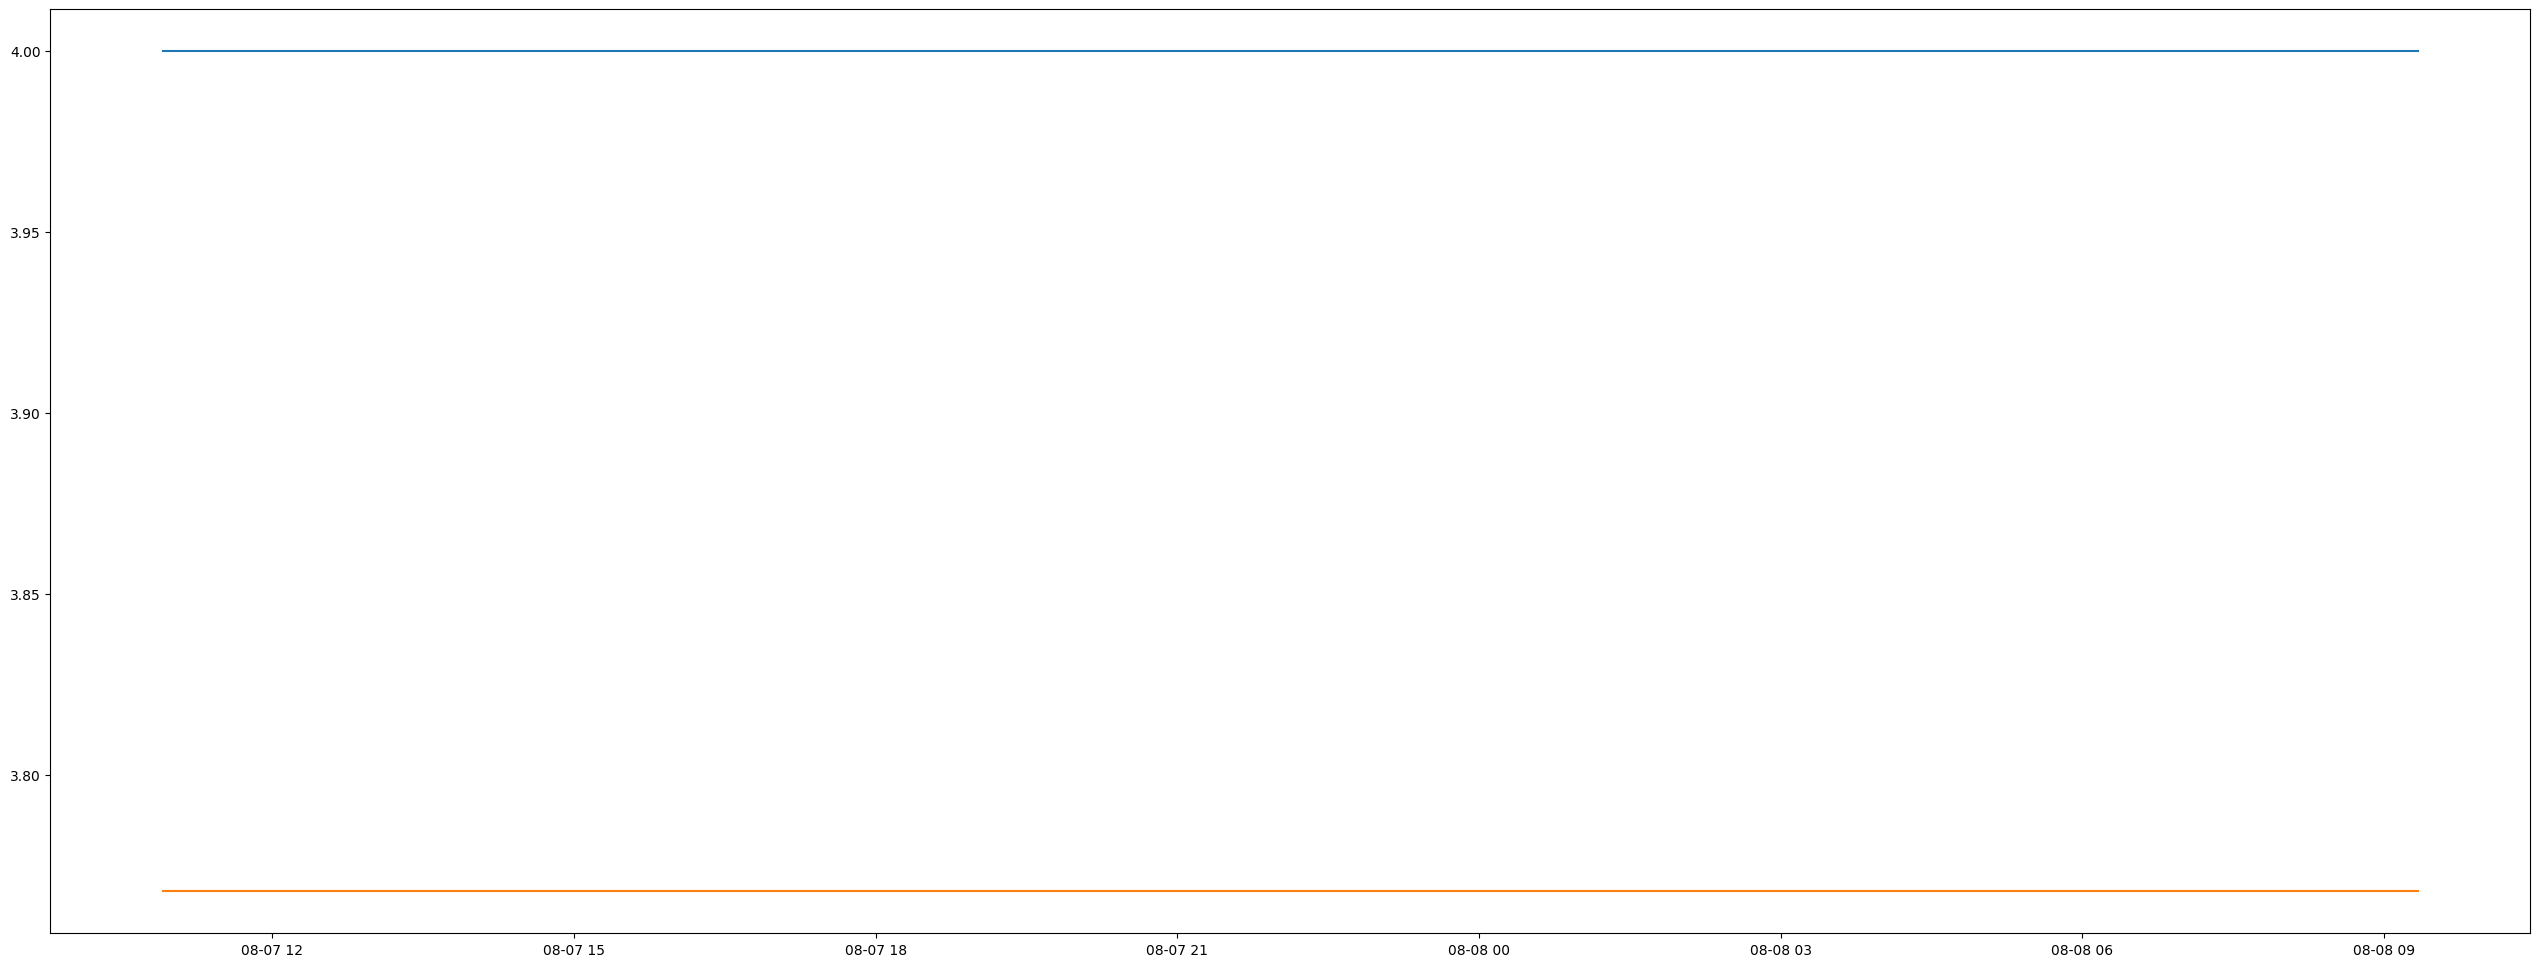

9/9 [==============================] - 4s 416ms/step


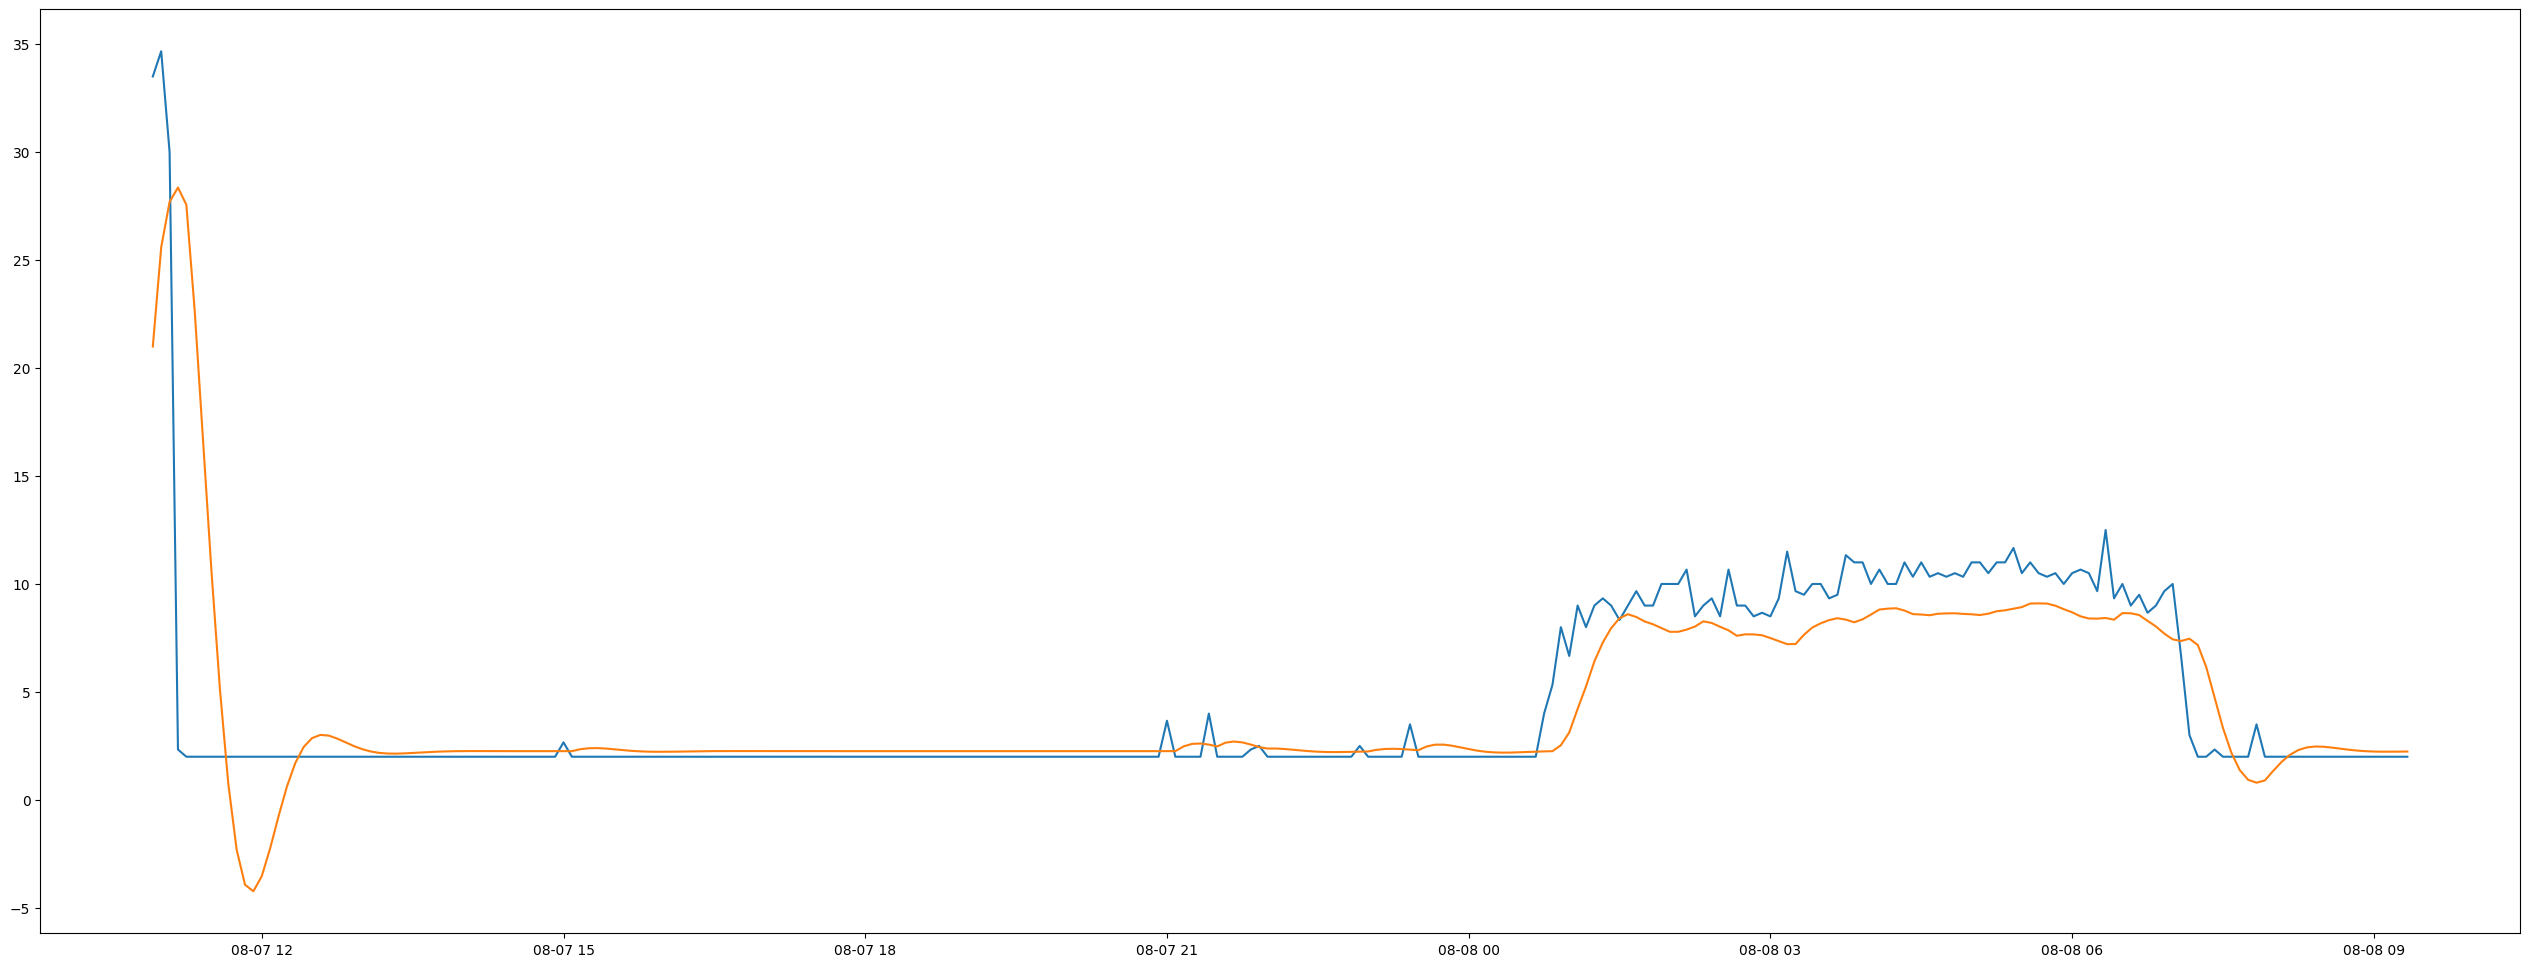

9/9 [==============================] - 3s 359ms/step


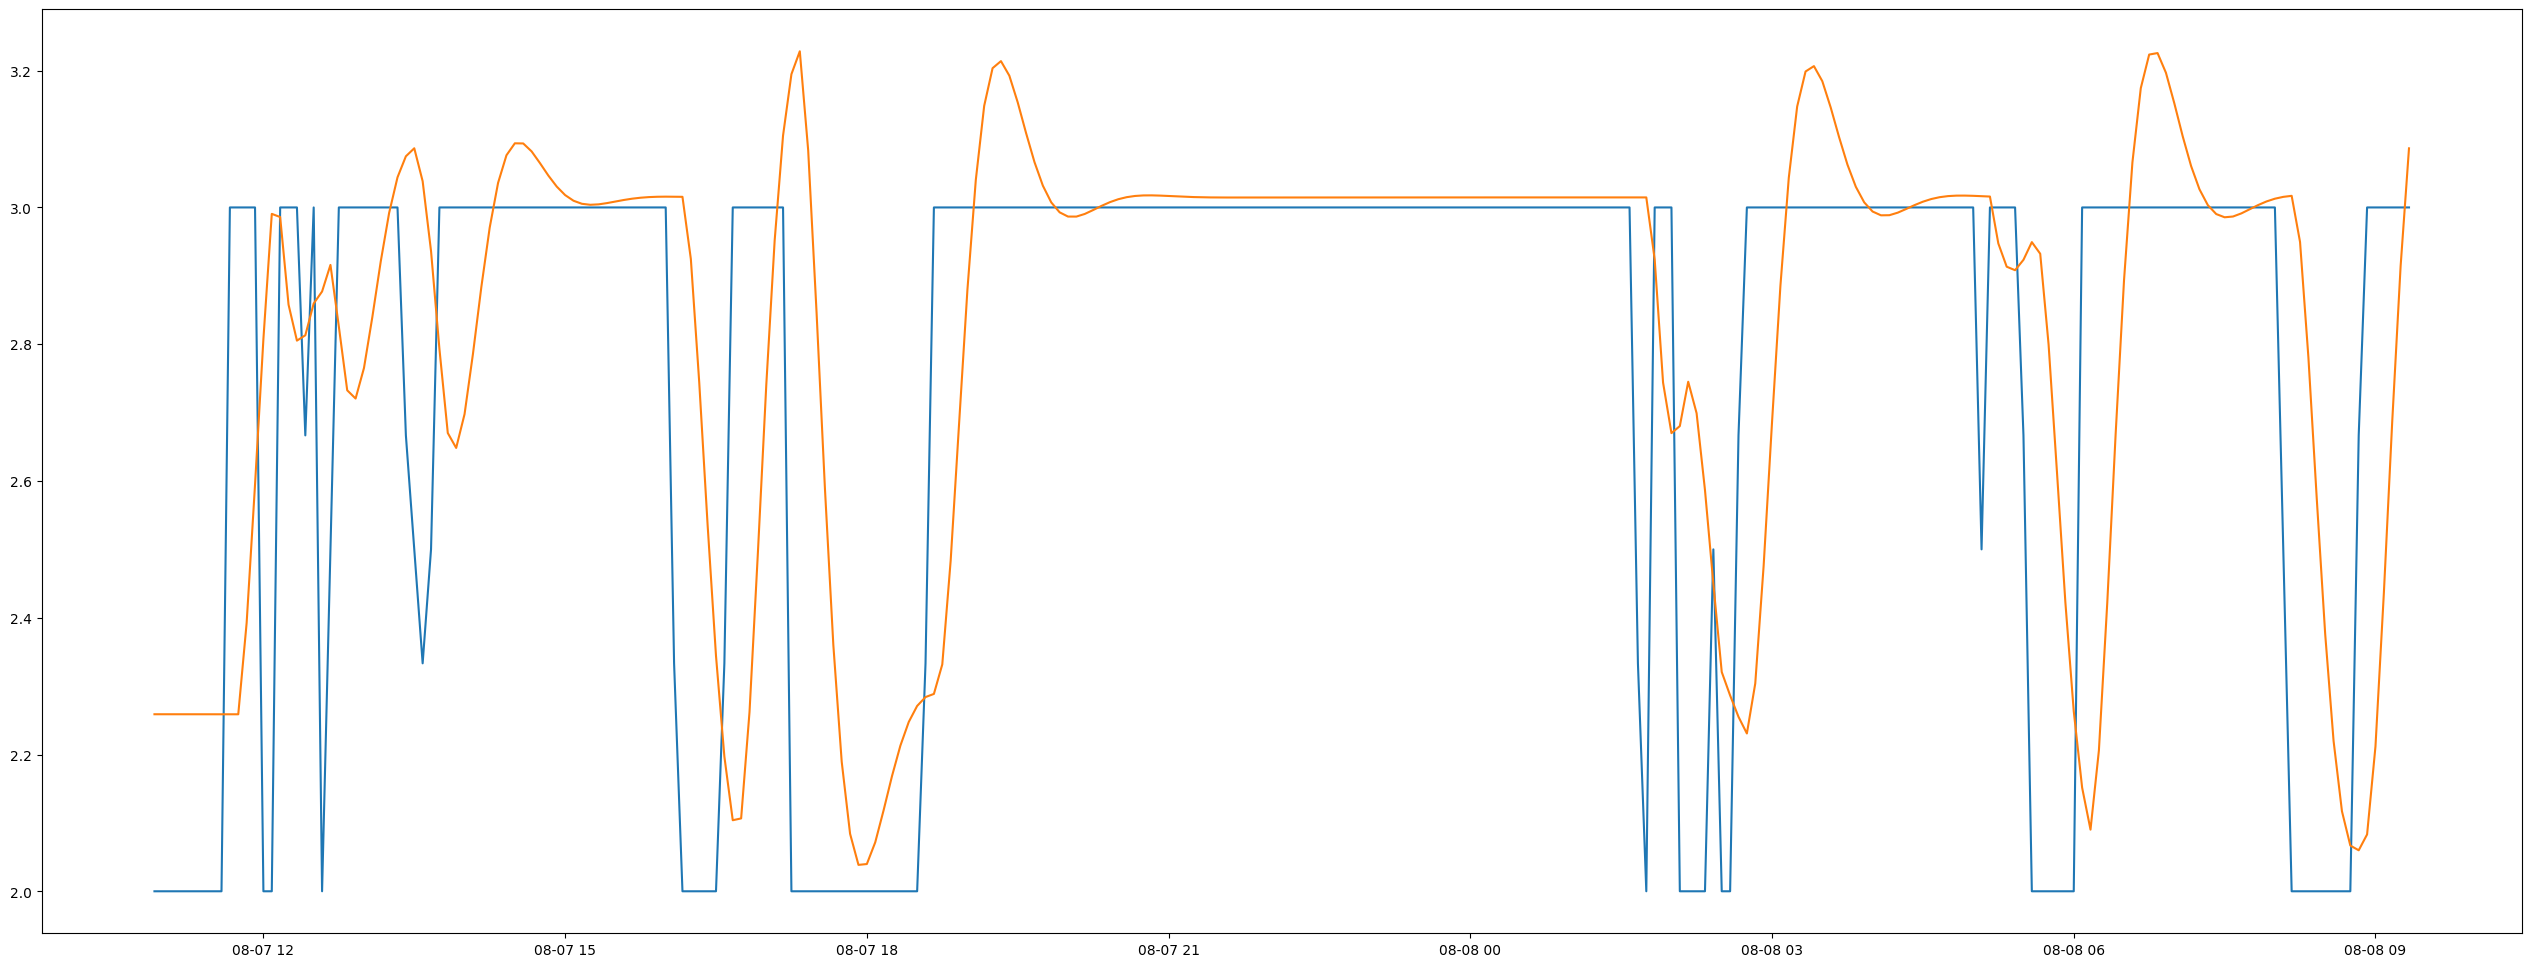

9/9 [==============================] - 4s 394ms/step


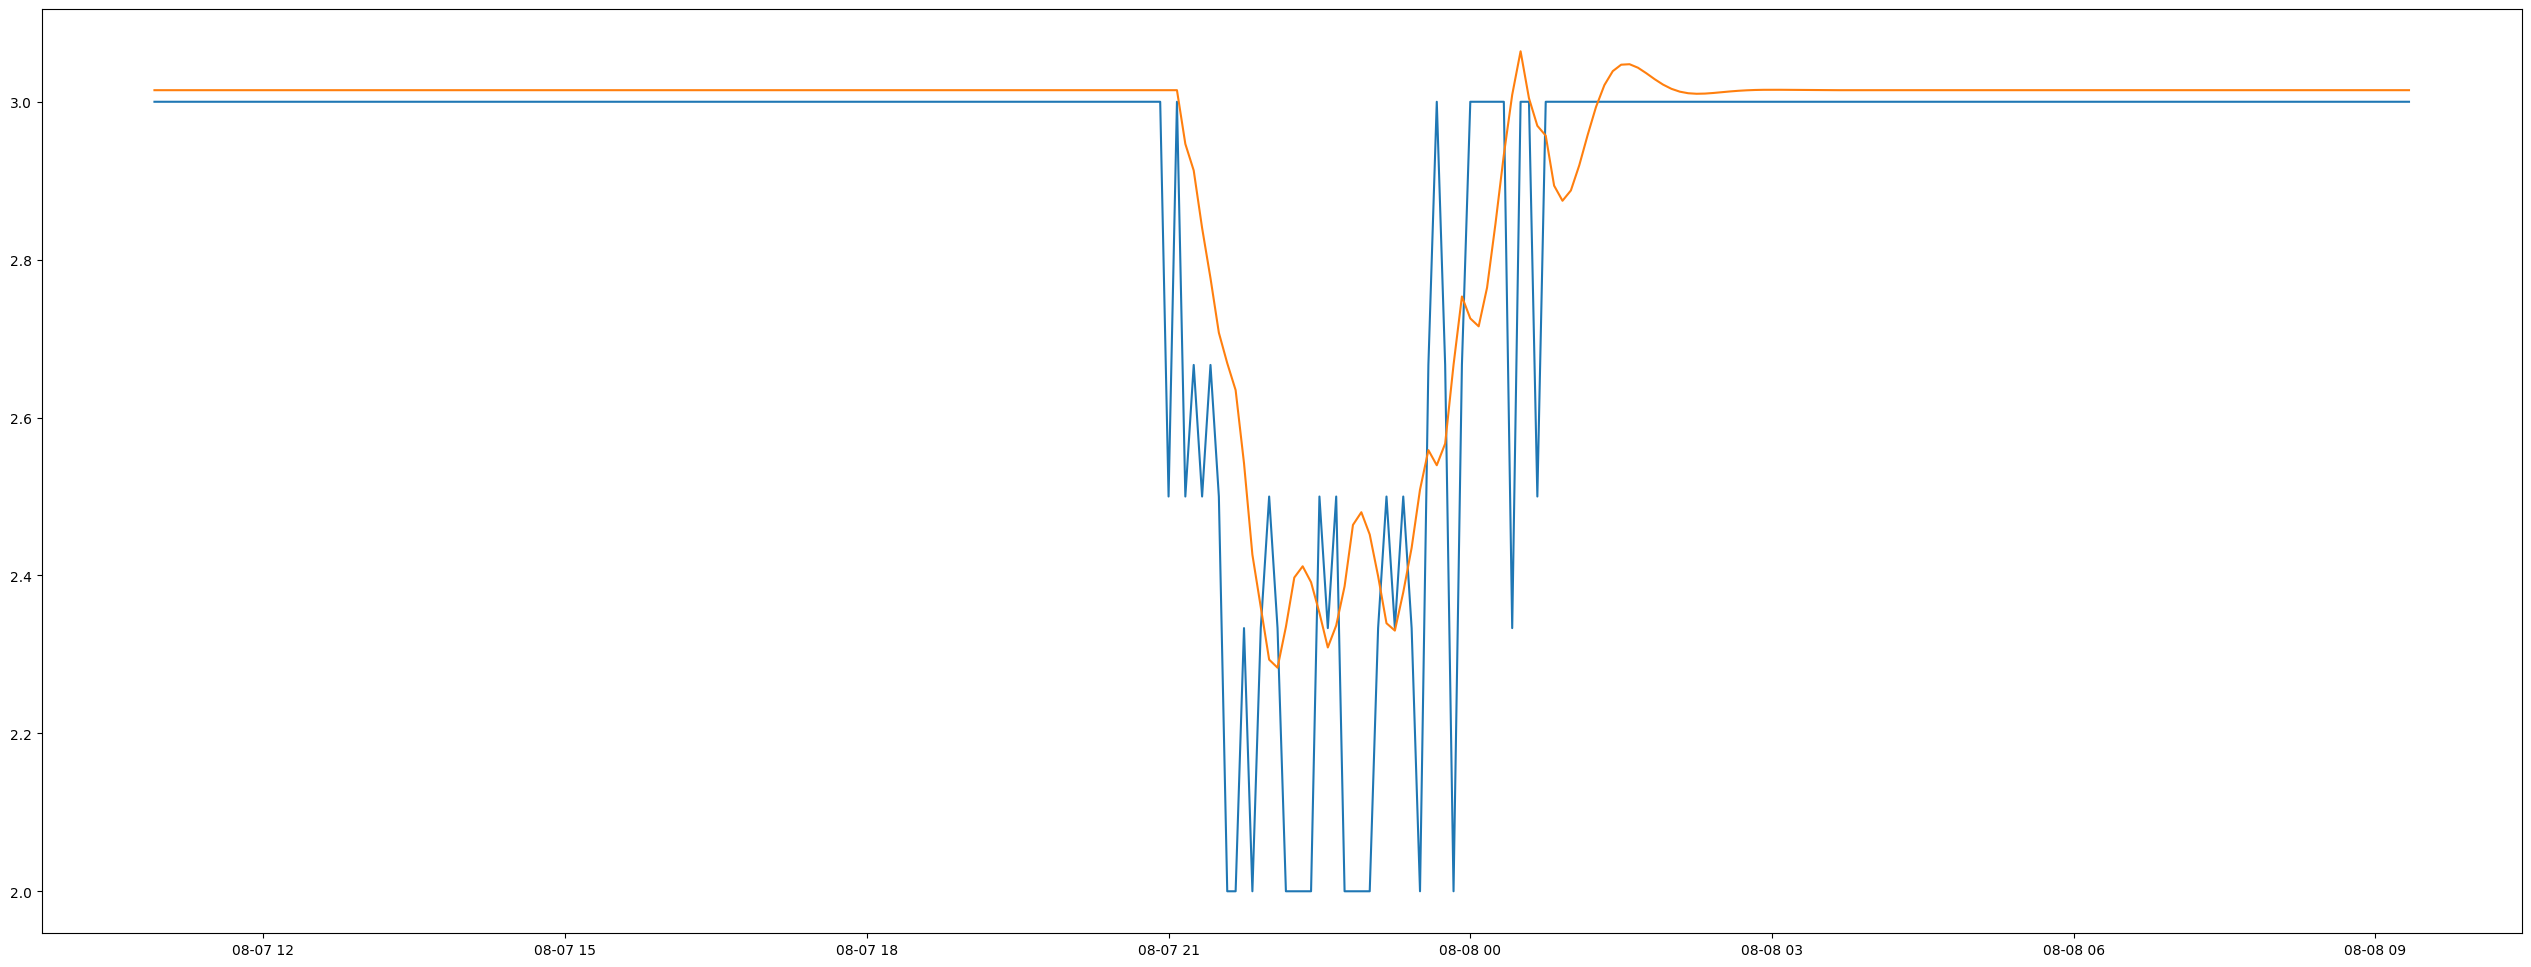

9/9 [==============================] - 3s 309ms/step


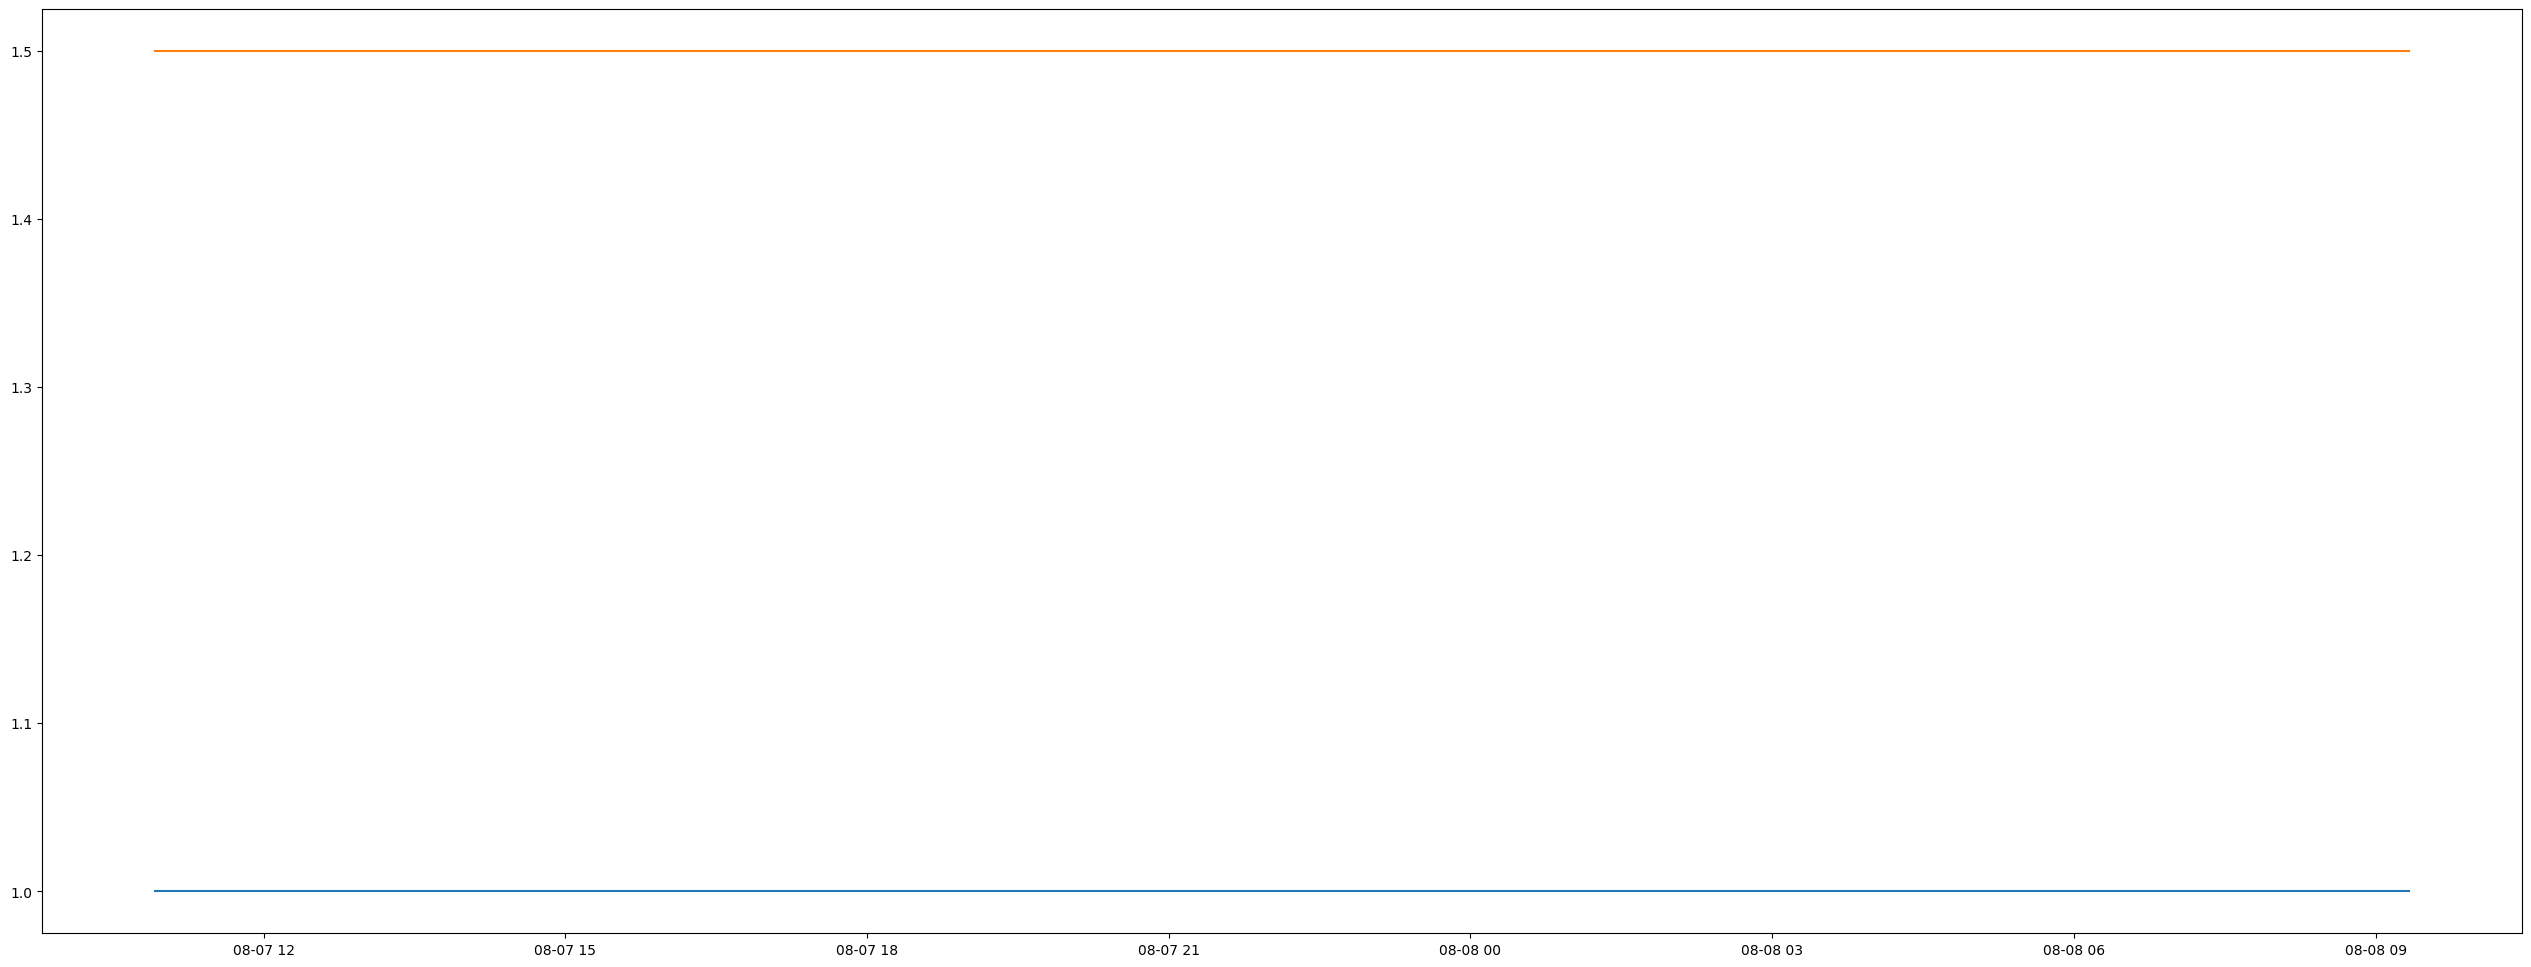

In [18]:
eval_each_type(test0)
eval_each_type(test1)
eval_each_type(test2)
eval_each_type(test3)
eval_each_type(test4)